**Chapter 4 – Regression**

*This notebook contains all the sample code and solutions to the exercises in chapter 2.*

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/hanchen92/handson-ml3/blob/main/04_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/hanchen92/handson-ml3/main/04_regression.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

# Data Collection

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

## Download the Data

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
# extra code – code to save the figures as high-res PNGs for the book
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Create a Test Set

### Stratified Sampling

In [4]:
from sklearn.model_selection import train_test_split

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [5]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)


for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


# Data Exploration

In [6]:
housing = strat_train_set.copy()

# Feature Engineering

In [7]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

## Custom Transformers

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [8]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

To create simple transformers:

In [9]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_



class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [10]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

# Data Cleaning

## Missing Data

Option 3: Replace by the median value

In [11]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()



C:\Users\alan_\AppData\Local\Temp\ipykernel_34756\6703280.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [12]:

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
X = imputer.transform(housing_num)


housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

##  Encoding Categorical Variables

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [13]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


### One Hot Encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

cat_encoder = OneHotEncoder(sparse_output=False)
cat_encoder.handle_unknown = "ignore"
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

Encoding the test set data directly may result in different columns.

## Feature Scaling

In [17]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config

from sklearn.compose import ColumnTransformer



def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [18]:
housing_prepared = preprocessing.fit_transform(housing)

In [19]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,8.708837e-08,9.712456e-01,...,7.114441e-04,3.070969e-17,1.314047e-01,5.740031e-01,0.0,0.0,0.0,1.0,0.0,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.181328e-01,9.738096e-14,...,3.045359e-27,5.437838e-01,1.735342e-09,2.275194e-10,1.0,0.0,0.0,0.0,0.0,0.907630


# Select and Train a Model

## Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels);

Let's try the full preprocessing pipeline on a few training instances:

In [21]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([242800., 375600., 127400.,  99600., 323100.])

Compare against the actual values:

In [22]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [23]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


68651.33102086962

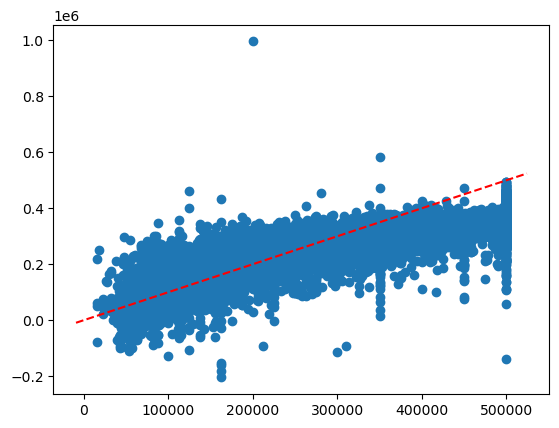

In [24]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'r--')

plt.plot(housing_labels,housing_predictions,'o')
abline(1,0)

In [25]:
from sklearn.model_selection import cross_val_score

# extra code – computes the error stats for the linear model
lin_rmses_cv = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_rmses_cv

array([69627.21155458, 68386.63041132, 65660.14457863, 80150.45317722,
       68587.36425968, 68796.78662362, 67702.32786824, 71097.97658006,
       68007.02594342, 69864.71554914])

In [26]:
np.mean(lin_rmses_cv)

69788.06365458971

## Forward Selection

In [27]:
from sklearn.feature_selection import SequentialFeatureSelector

preprocessing.fit(housing)
housing_design = pd.DataFrame(preprocessing.transform(housing), columns = preprocessing.get_feature_names_out())


sfs = SequentialFeatureSelector(LinearRegression(), scoring = "neg_mean_squared_error", direction = "forward", cv =10);
sfs.fit(housing_design, housing_labels);

In [28]:
housing_design.columns

Index(['bedrooms__ratio', 'rooms_per_house__ratio', 'people_per_house__ratio',
       'log__total_bedrooms', 'log__total_rooms', 'log__population',
       'log__households', 'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'],
      dtype='object')

In [29]:
sfs.get_feature_names_out()

array(['bedrooms__ratio', 'log__total_rooms', 'log__population',
       'log__households', 'log__median_income',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity', 'geo__Cluster 9 similarity',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [30]:
housing_design_forward = sfs.transform(housing_design)

In [31]:
lin_reg_forward = LinearRegression()
lin_reg_forward.fit(housing_design_forward, housing_labels)

housing_predictions_forward = lin_reg_forward.predict(housing_design_forward)



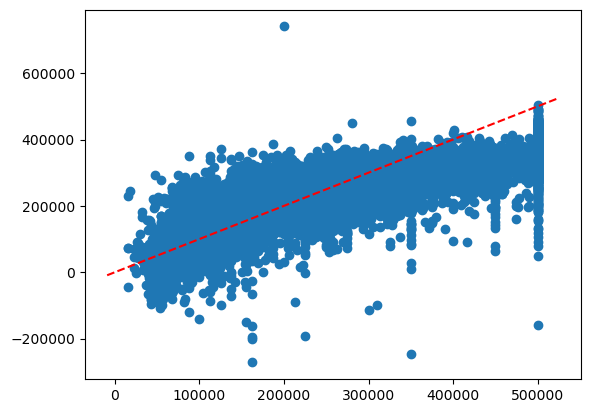

In [32]:
plt.plot(housing_labels,housing_predictions_forward,'o')
abline(1,0)

In [33]:
lin_rmse_forward = mean_squared_error(housing_labels, housing_predictions_forward,
                              squared=False)
lin_rmse_forward

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


70101.95205780177

In [34]:
lin_rmse_forward_cv = -cross_val_score(lin_reg_forward, housing_design_forward, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [35]:
np.mean(lin_rmse_forward_cv)

70262.09679820383

##  Lasso

In [36]:
from sklearn.linear_model import LassoCV


model_lasso = LassoCV(cv=10, random_state=0)
model_lasso.fit(housing_design, housing_labels)
model_lasso.coef_

array([  8886.67459785,   1952.29128657,   6863.23183815,     -0.        ,
        22033.29410616, -76183.73208632,  54457.22174699,  63159.788222  ,
        35078.8258284 ,  17643.9643352 ,  73953.64999131,     -0.        ,
           -0.        ,     -0.        ,     -0.        , -14358.8345447 ,
        -3270.48325861,  61184.85916891,     -0.        , -42991.29725078,
            0.        ,      0.        ,  28835.0445181 ,   7596.7632402 ])

In [37]:
sum(model_lasso.coef_!=0)

16

In [38]:
housing_design.columns[model_lasso.coef_!=0]

Index(['bedrooms__ratio', 'rooms_per_house__ratio', 'people_per_house__ratio',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype='object')

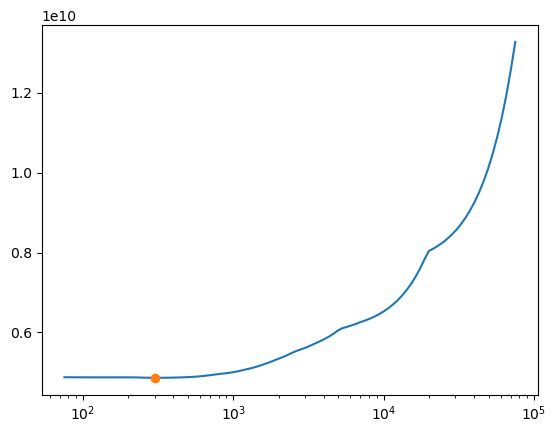

In [39]:
plt.plot(model_lasso.alphas_,model_lasso.mse_path_.mean(axis=1))
plt.plot(model_lasso.alpha_,model_lasso.mse_path_.mean(axis=1)[model_lasso.alphas_==model_lasso.alpha_],'o')
plt.xscale('log')

In [40]:
model_lasso_all = make_pipeline(preprocessing, model_lasso)
model_lasso_all.fit(housing, housing_labels)

housing_predictions_lasso = model_lasso_all.predict(housing)

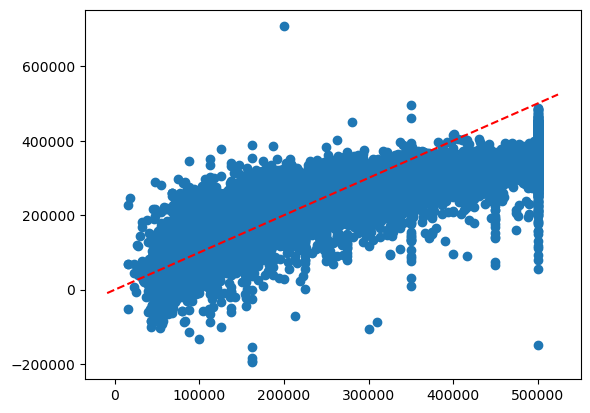

In [41]:
plt.plot(housing_labels,housing_predictions_lasso,'o')
abline(1,0)

In [42]:
np.sqrt(model_lasso.mse_path_.mean(axis=1)[model_lasso.alphas_==model_lasso.alpha_][0])

69739.02441087582

## Decision Tree

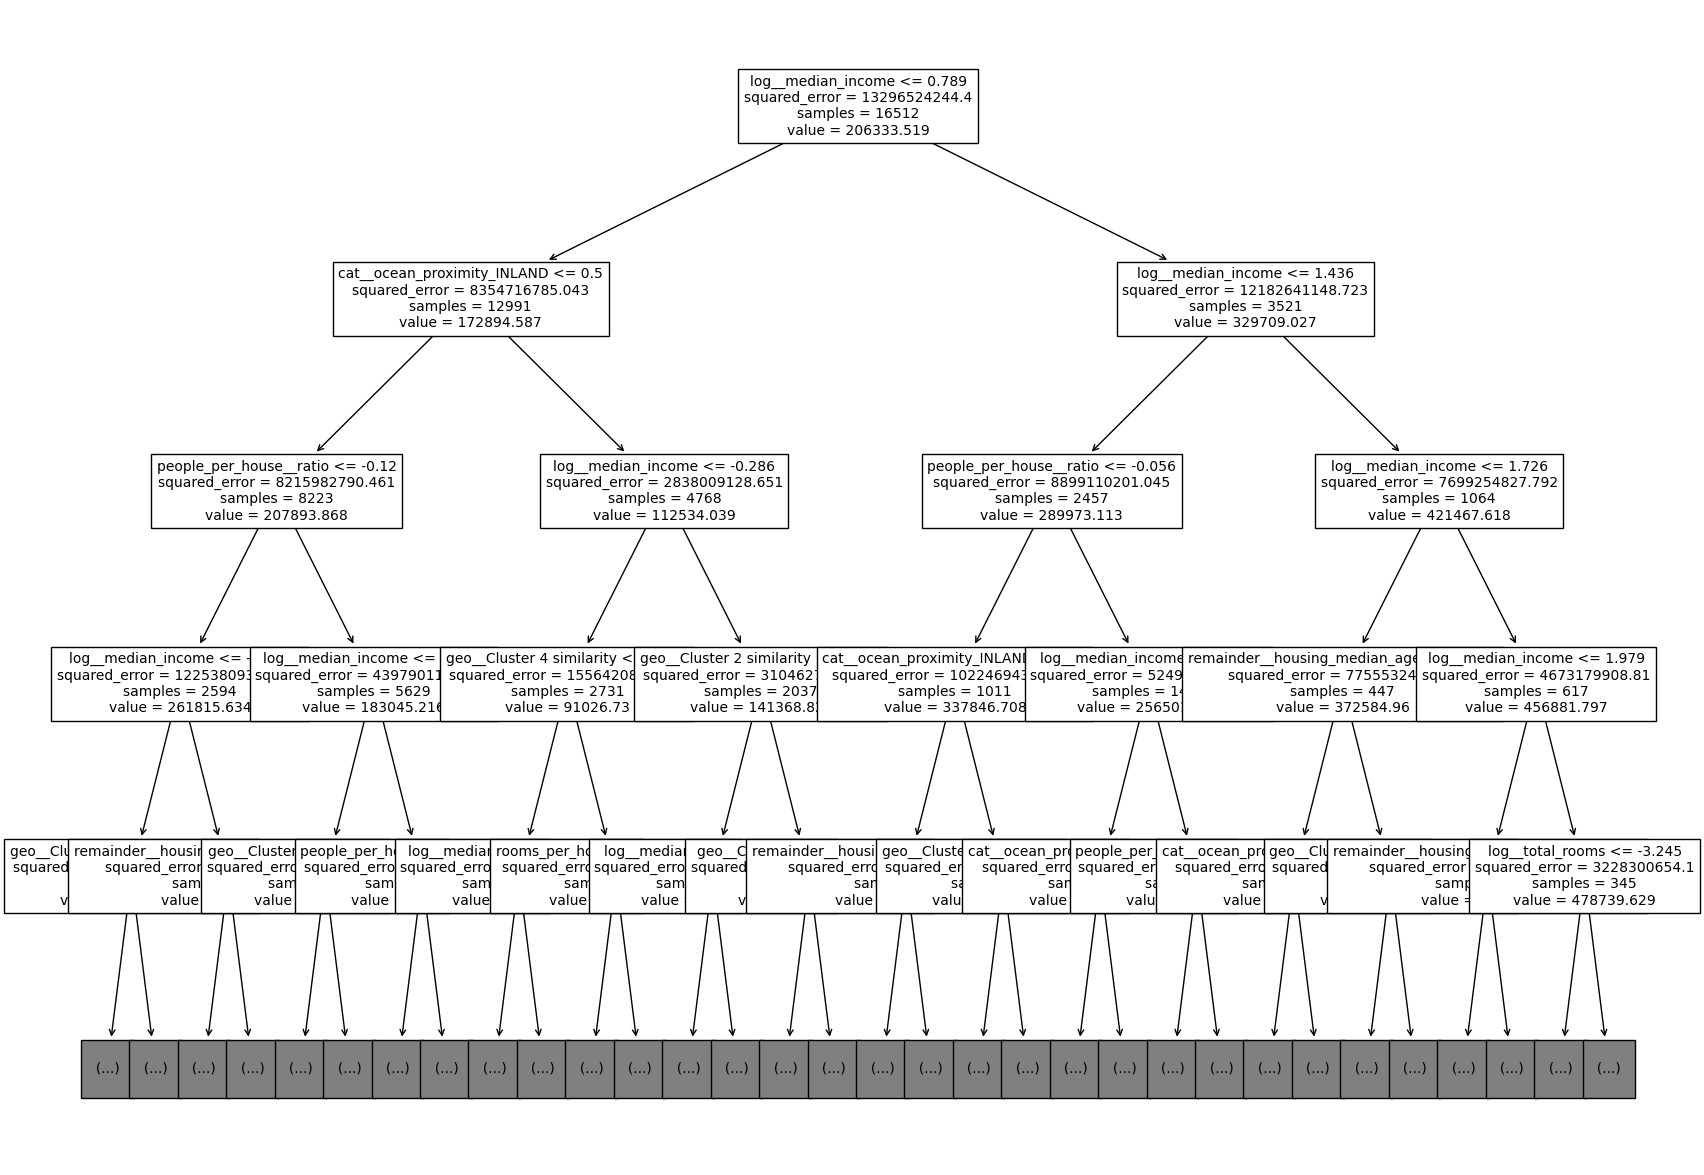

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree


tree_reg = DecisionTreeRegressor(random_state=42, min_samples_leaf=5)
tree_reg.fit(housing_design, housing_labels);


fig, axes= plt.subplots(1, 1, figsize=(20, 15))
plot_tree(tree_reg, max_depth=4, feature_names=preprocessing.get_feature_names_out(),fontsize=10)
plt.show()

In [44]:
tmp_path  = tree_reg.cost_complexity_pruning_path(housing_design, housing_labels)

ccp_alphas, impurities = tmp_path.ccp_alphas, tmp_path.impurities

In [45]:
tmp_cpp_len = len(ccp_alphas)
tmp_step = int(np.floor(tmp_cpp_len/(20)))
tmp_ccp_alpha = ccp_alphas[0:tmp_cpp_len:tmp_step]
tmp_all_cv_rmse = []
for i, tmp_alpha in enumerate(tmp_ccp_alpha):
    if i%5==0:
        print(i)
    tmp_tree_reg = DecisionTreeRegressor(random_state=42, ccp_alpha = tmp_alpha)
    tmp_all_cv_rmse.append(-1*np.mean(cross_val_score(tmp_tree_reg, housing_design, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=5)))

0
5
10
15
20


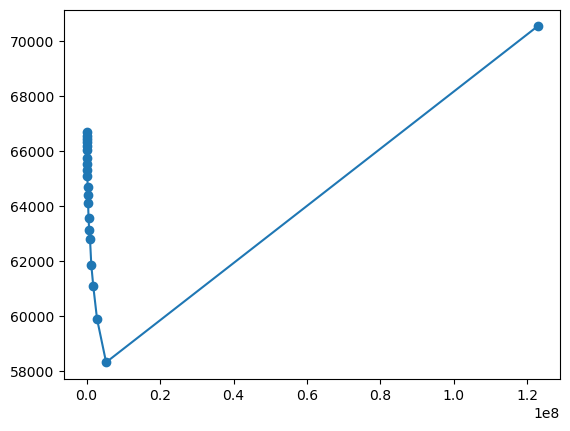

In [46]:
plt.plot(tmp_ccp_alpha,tmp_all_cv_rmse,'o-')

In [47]:
np.where(tmp_all_cv_rmse==np.min(tmp_all_cv_rmse))[0][0]

19

In [48]:
tmp_cv_best_alpha = tmp_ccp_alpha[np.where(tmp_all_cv_rmse==np.min(tmp_all_cv_rmse))[0][0]]

In [49]:
tree_reg = DecisionTreeRegressor(random_state=42, ccp_alpha=tmp_cv_best_alpha)

tree_reg_all = make_pipeline(preprocessing, tree_reg)
tree_reg_all.fit(housing, housing_labels);


housing_predictions = tree_reg_all.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


50819.241378154395

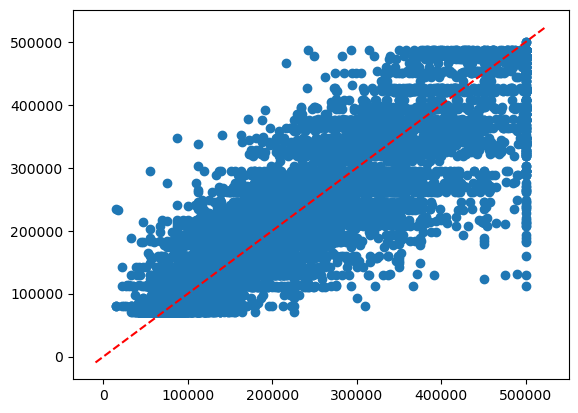

In [50]:
plt.plot(housing_labels,housing_predictions,'o')
abline(1,0)

In [51]:
tree_rmses_cv = -cross_val_score(tree_reg_all, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [52]:
np.mean(tree_rmses_cv)

58538.79357913191

## Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))


forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


17547.52124624957

In [54]:
forest_cv_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
np.mean(forest_cv_rmses)

47002.931705954674

## Gradient Boosting

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

boost_reg = make_pipeline(preprocessing,
                           GradientBoostingRegressor(random_state=42, n_estimators=500))

boost_reg.fit(housing, housing_labels)
housing_predictions = boost_reg.predict(housing)
boost_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
boost_rmse

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


38931.69694553355

In [56]:
boost_cv_rmses = -cross_val_score(boost_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
np.mean(boost_cv_rmses)

46557.03986655051

In [57]:
all_methods = ["Linear Regression","Forward Selection","Lasso","Tree","Random Forest","Boosting"]
all_rmse_cv = [np.mean(lin_rmses_cv), np.mean(lin_rmse_forward_cv), np.sqrt(model_lasso.mse_path_.mean(axis=1)[model_lasso.alphas_==model_lasso.alpha_][0]), np.mean(tree_rmses_cv), np.mean(forest_cv_rmses), np.mean(boost_cv_rmses)]
pd.DataFrame({"method": all_methods,"rmse_csv": all_rmse_cv})

,method,rmse_csv
0,Linear Regression,69788.063655
1,Forward Selection,70262.096798
2,Lasso,69739.024411
3,Tree,58538.793579
4,Random Forest,47002.931706
5,Boosting,46557.039867


# Fine-Tune Your Model

## Grid Search

**Warning:** the following cell may take a few minutes to run:

In [58]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B139D7D460>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

You can get the full list of hyperparameters available for tuning by looking at `full_pipeline.get_params().keys()`:

In [59]:
# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'prepr

The best hyperparameter combination found:

In [60]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [61]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001B...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B13BA69370>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

Let's look at the score of each hyperparameter combination tested during the grid search:

In [62]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43536,43753,44569,43953
13,15,8,44084,44205,44863,44384
14,15,10,44368,44496,45200,44688
7,10,6,44251,44628,45857,44912
9,10,6,44251,44628,45857,44912


## Randomized Search

In [63]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

Try 30 (`n_iter` × `cv`) random combinations of hyperparameters:

**Warning:** the following cell may take a few minutes to run:

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B13BB29E20>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B13BB56300>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [65]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41014,42151,42695,41953
8,32,7,41604,42200,43219,42341
0,41,16,42106,42743,43443,42764
5,42,4,41835,42925,43557,42772
2,23,8,42421,43094,43856,43124


**Bonus section: how to choose the sampling distribution for a hyperparameter**

* `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
* `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
* `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
* `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.


Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for `randint()`, `uniform()`, `geom()` and `expon()`:

## Analyze the Best Models and Their Errors

In [66]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [67]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.03807069074492323, 'geo__Cluster 3 similarity'),
 (0.025643913400094472, 'geo__Cluster 22 similarity'),
 (0.02179127543243723, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.014888464257396877, 'geo__Cluster 40 similarity'),
 (0.014488389218107146, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732161, 'geo__Cluster 38 similarity'),
 (0.013625709964722737, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 simila

## Evaluate Your System on the Test Set

In [68]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41549.20158097943


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


We can compute a 95% confidence interval for the test RMSE:

## Model persistence using joblib

Save the final model:

In [69]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Now you can deploy this model to production. For example, the following code could be a script that would run in production:

In [70]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [71]:
predictions

array([439808.14, 455211.06, 109492.  ,  98208.  , 340021.04])

You could use pickle instead, but joblib is more efficient.